In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/opt/anaconda3/envs/molgen/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
config_path = "config/mcts_smiles.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_name, model_dir, lang_class_name, lang_path = (conf.get(k) for k in ("model_class_name", "model_dir", "lang_class_name", "lang_path"))
lang_class = get_class_from_package("language", lang_class_name)
lang = lang_class.load(repo_root + lang_path)
# if lang_class_name.endswith("HELM"): #TODO: should be removed after .lang inclusion
#     lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_package("transition", model_class_name)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_name, reward_conf = (conf.get(k) for k in ("reward_class_name", "reward_conf"))
reward_class = get_class_from_package("reward", reward_class_name)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_name", "policy_conf"))
policy_class = get_class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_package("filter", s.pop("filter_class_name"))
    filters.append(filter_class(**s))

Search is started.
0- time: 0.09, count_rollouts: 2, reward: 0.391906069998332, node: O=C(Nc1ccnc2ccccc12)c1ccc(Cl)cc1
1- time: 0.15, count_rollouts: 3, reward: -0.09545052801170568, node: N#CCn1nnc(C(=O)N2CCC2)n1
2- time: 0.59, count_rollouts: 13, reward: 0.33688095272870183, node: O=C(CCOc1ccc(OC(F)(F)F)cc1F)N1CCCCC1
3- time: 0.77, count_rollouts: 17, reward: 0.37848658361589343, node: c1noc(C)c1NC(=O)[C@@H](C)CCc1ccc(F)cc1Cl
4- time: 0.97, count_rollouts: 21, reward: 0.2234457324401305, node: S=C(Nc1ccccc1)c1cc(OC)cnn1
5- time: 1.32, count_rollouts: 29, reward: 0.08507386164577083, node: NC(=O)CC[C@H]1NCCCN1C(=O)c1ccccc1F
6- time: 1.38, count_rollouts: 30, reward: 0.18106154841103864, node: Nc1ccc(CC(=O)N2CCC[C@@H]2C)cc1OC
7- time: 1.59, count_rollouts: 35, reward: 0.4129247002462276, node: Cc1ccc(NC(=O)N(C)c2ccccc2C(=O)N(C)CC(C)C)cc1
8- time: 1.71, count_rollouts: 37, reward: 0.32412544961279793, node: FCc1ccc(NC(=O)NC(=O)[C@@H](C)N2CCCN(c3ccccc3)C2)cc1
9- time: 2.13, count_rollout

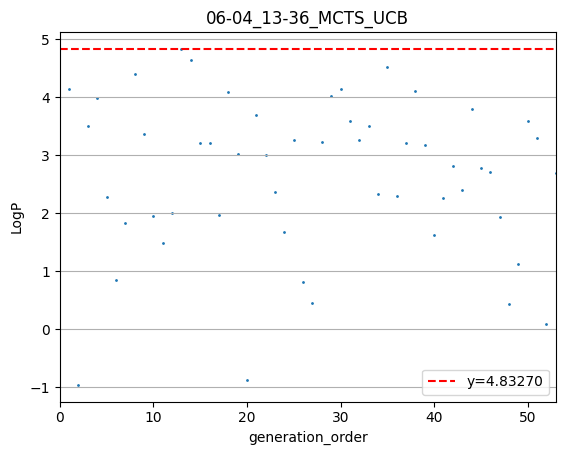

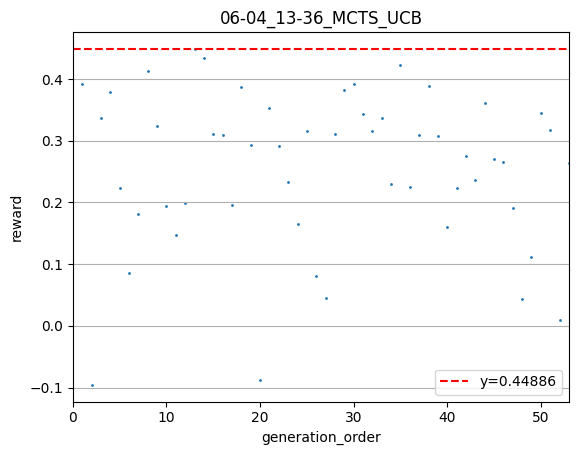

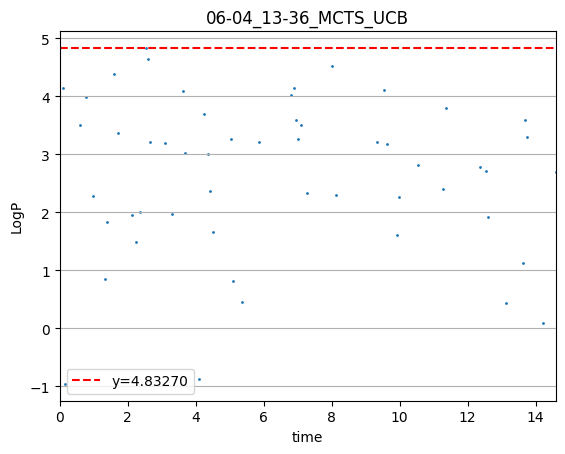

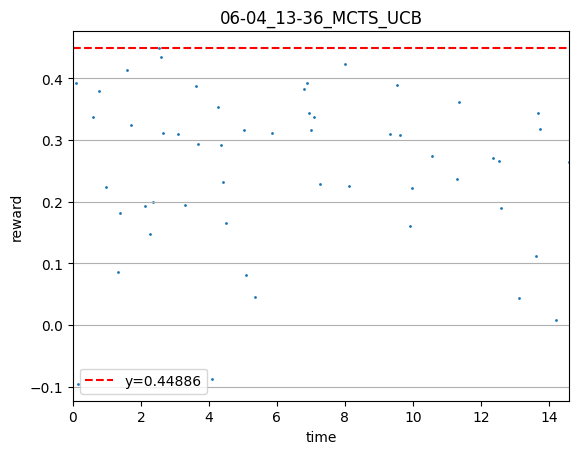

Search is completed.


In [16]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)